# Import Libraries

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import itertools
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

# Read Data

In [2]:
train_data='/kaggle/input/brain-tumor-mri-dataset/Training'
filepaths=[]
labels=[]

folds=os.listdir(train_data)

for fold in folds:
    foldpath=os.path.join(train_data,fold)
    filelist=os.listdir(foldpath)
    
    for fpath in filelist:
        fillpath=os.path.join(foldpath,fpath)
        
        labels.append(fold)
        filepaths.append(fillpath)
        
file_series=pd.Series(filepaths,name='filepaths')
label_series=pd.Series(labels,name='labels')
train_df=pd.concat([file_series,label_series],axis=1)

In [3]:
train_df

,filepaths,labels
0,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
...,...,...
5707,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5708,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5709,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5710,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma


In [4]:
test_data='/kaggle/input/brain-tumor-mri-dataset/Testing'
filepaths=[]
labels=[]

folds=os.listdir(test_data)

for fold in folds:
    foldpath=os.path.join(test_data,fold)
    filelist=os.listdir(foldpath)
    
    for fpath in filelist:
        fillpath=os.path.join(foldpath,fpath)
        
        labels.append(fold)
        filepaths.append(fillpath)
        
file_series=pd.Series(filepaths,name='filepaths')
label_series=pd.Series(labels,name='labels')
ts_df=pd.concat([file_series,label_series],axis=1)

In [5]:
ts_df

,filepaths,labels
0,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
...,...,...
1306,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1307,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1308,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1309,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma


# Preprocessing

In [6]:
val_df, test_df= train_test_split(ts_df,test_size=0.5,random_state= 43)

In [7]:
val_df

,filepaths,labels
185,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
436,/kaggle/input/brain-tumor-mri-dataset/Testing/...,notumor
1149,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
999,/kaggle/input/brain-tumor-mri-dataset/Testing/...,meningioma
671,/kaggle/input/brain-tumor-mri-dataset/Testing/...,notumor
...,...,...
307,/kaggle/input/brain-tumor-mri-dataset/Testing/...,notumor
16,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
58,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
277,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary


###  image data generator

In [8]:
batch_size = 16
image_size = (224, 224)

train_genrator = ImageDataGenerator()
test_genrator = ImageDataGenerator()


train_genrator = train_genrator.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= image_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_genrator = test_genrator.flow_from_dataframe( val_df, x_col= 'filepaths', y_col= 'labels', target_size= image_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_genrator = test_genrator.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= image_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


### Show sample from train data

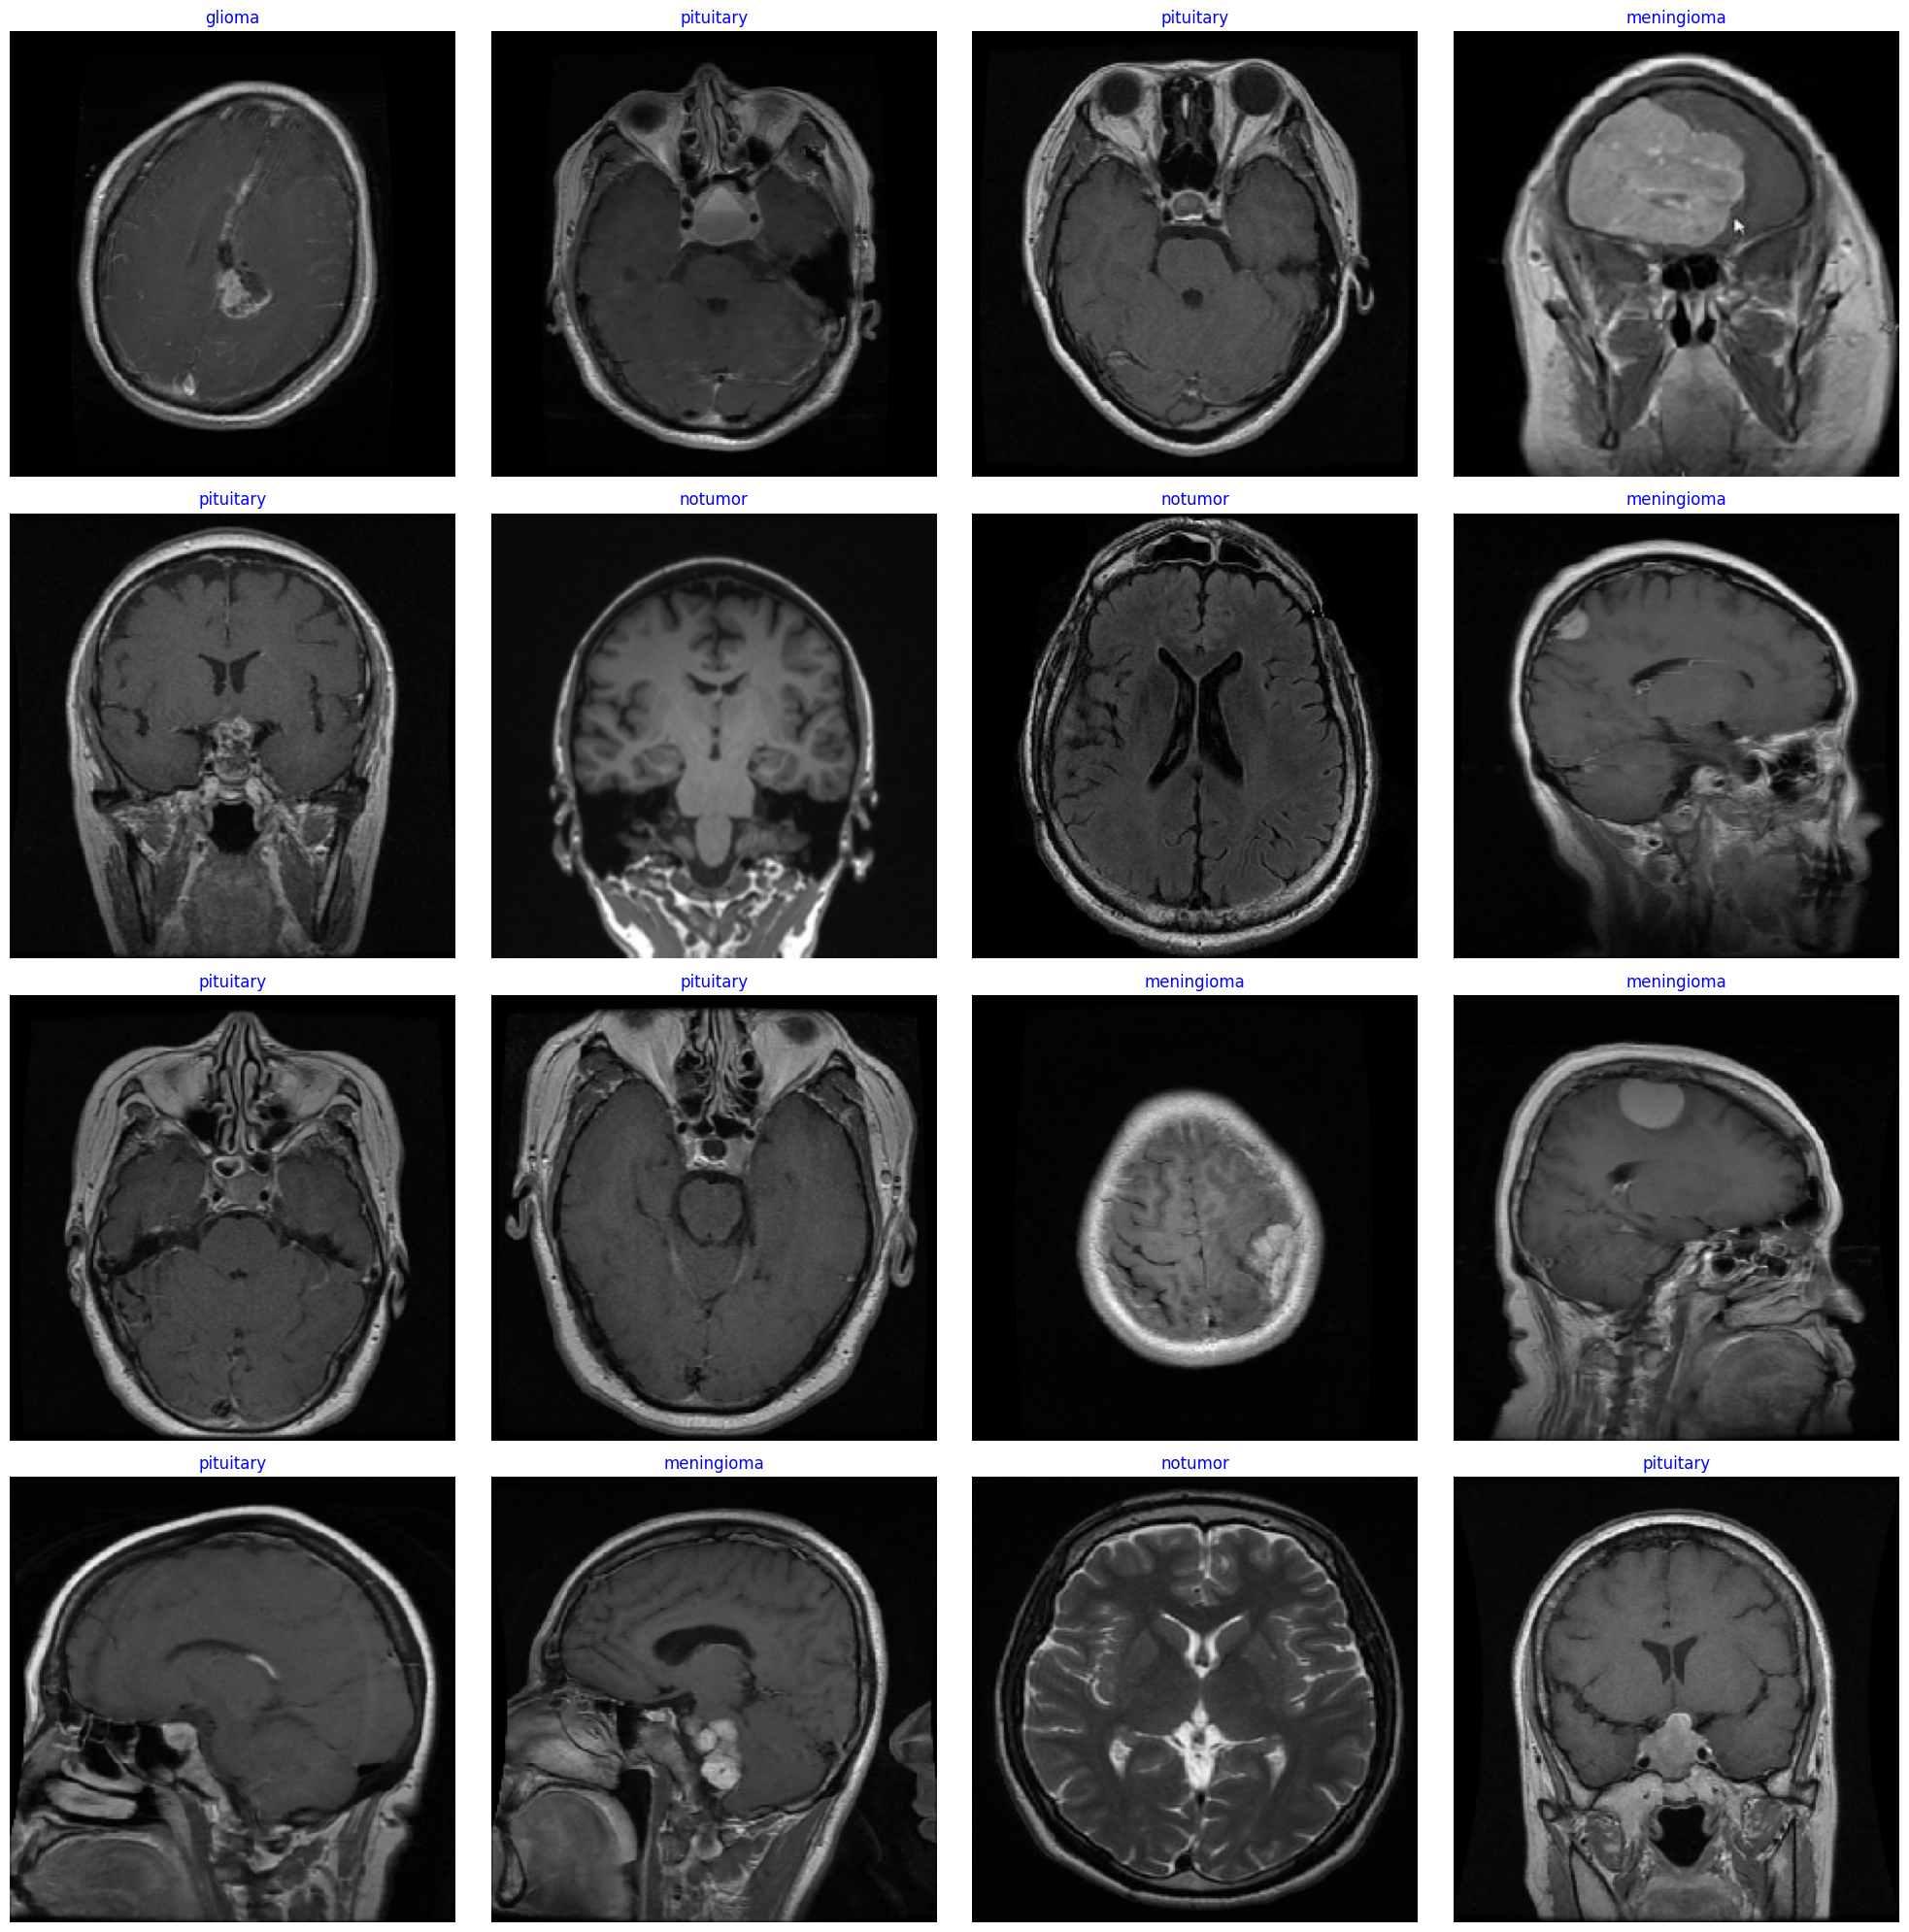

In [9]:
g_dict = train_genrator.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_genrator)      # get a batch size samples from the generator
# # difference between next iterator and for iterator


plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.tight_layout()
plt.show()

# Build Model

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_count = len(list(train_genrator.class_indices.keys())) # to define number of classes in dense layer

model = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    
    Dense(256,activation = "relu"),
    Dense(64,activation = "relu"),
    Dense(class_count, activation = "softmax")
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy',Precision(), Recall()])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,154,180 (80.70 MB)

 Trainable params: 21,154,180 (80.70 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = model.fit(train_genrator, epochs= 10, verbose= 1, validation_data= valid_genrator, shuffle= False)

Epoch 1/10


I0000 00:00:1727853768.693108     103 service.cc:145] XLA service 0x7b10a8003e00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727853768.693272     103 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/357 ━━━━━━━━━━━━━━━━━━━━ 1:51:50 19s/step - accuracy: 0.5625 - loss: 1.3015 - precision: 0.0000e+00 - recall: 0.0000e+00

I0000 00:00:1727853782.007353     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


357/357 ━━━━━━━━━━━━━━━━━━━━ 76s 160ms/step - accuracy: 0.4345 - loss: 40.9462 - precision: 0.6348 - recall: 0.2125 - val_accuracy: 0.6916 - val_loss: 0.7365 - val_precision: 0.7254 - val_recall: 0.6534
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.7605 - loss: 0.5667 - precision: 0.7901 - recall: 0.7233 - val_accuracy: 0.7954 - val_loss: 0.5845 - val_precision: 0.7997 - val_recall: 0.7863
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.8746 - loss: 0.3426 - precision: 0.8872 - recall: 0.8580 - val_accuracy: 0.8275 - val_loss: 0.4503 - val_precision: 0.8310 - val_recall: 0.8107
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.9150 - loss: 0.2527 - precision: 0.9188 - recall: 0.9043 - val_accuracy: 0.8656 - val_loss: 0.3393 - val_precision: 0.8736 - val_recall: 0.8550
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 119ms/step - accuracy: 0.9216 - loss: 0.2035 - precision: 0.9282 - recall: 0.9163 - val_accuracy: 0.9038 - val_los

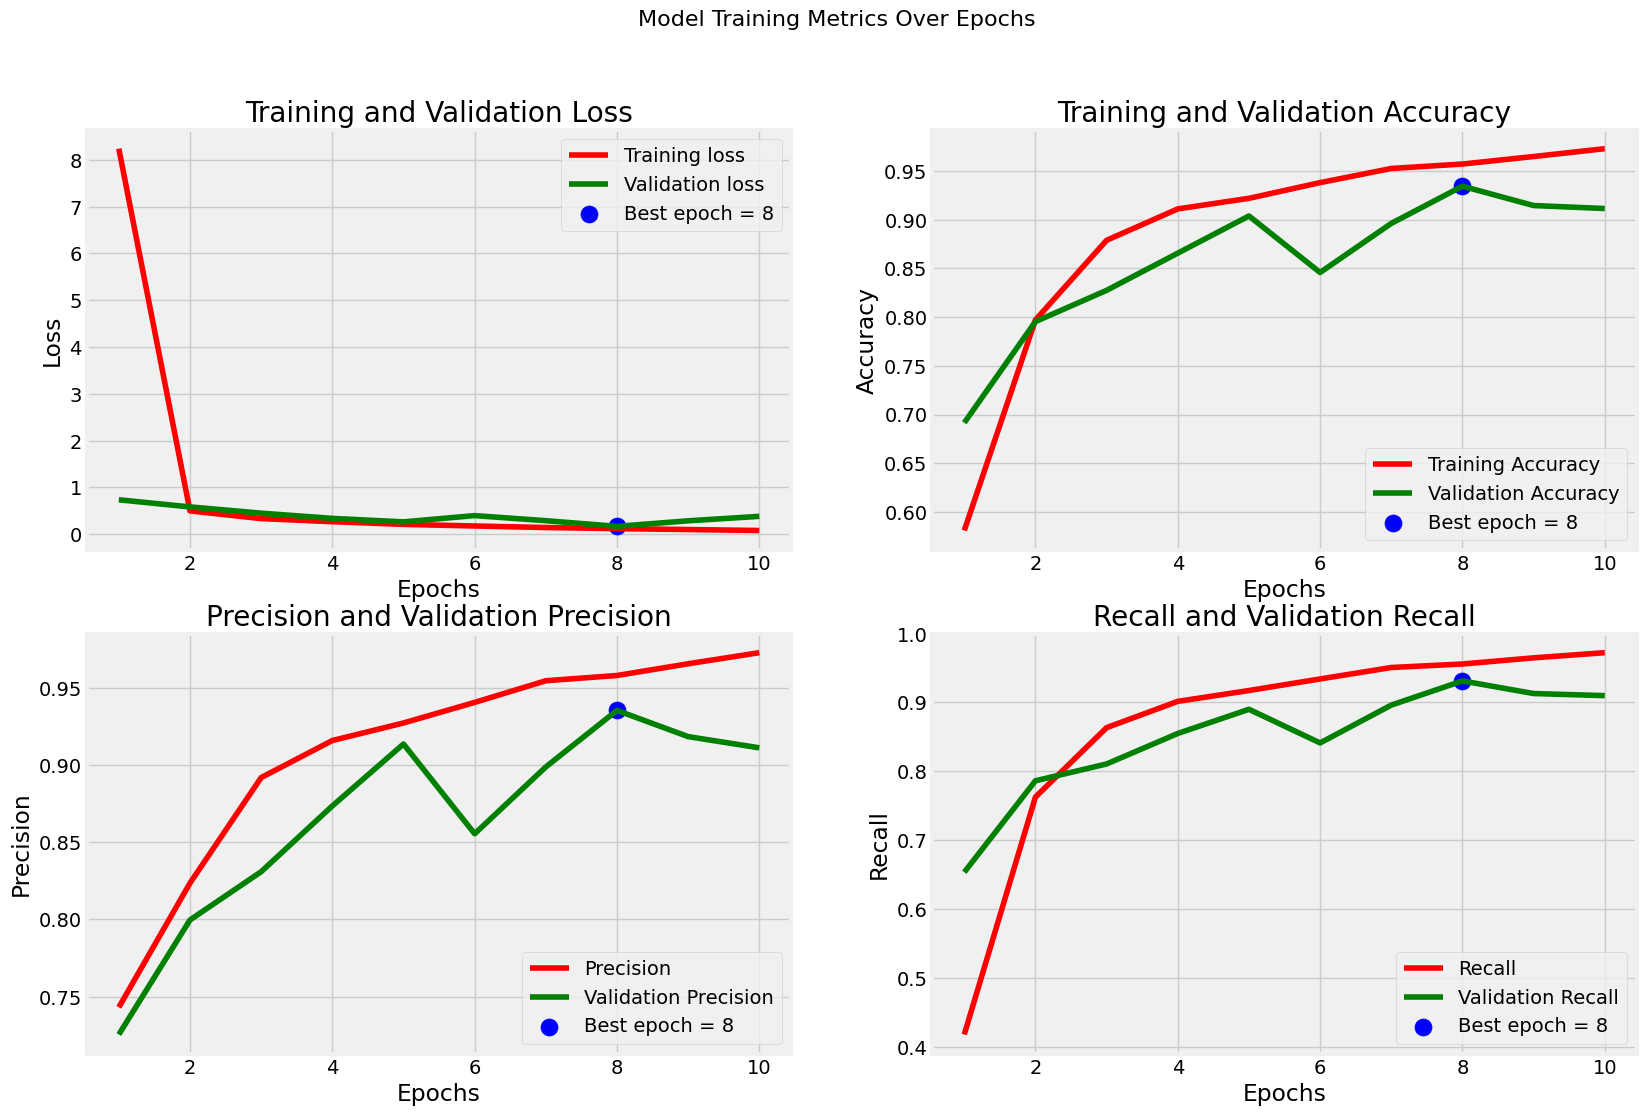

In [12]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
tr_per = history.history['precision']
tr_recall = history.history['recall']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
val_per = history.history['val_precision']
val_recall = history.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'


plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()


# Evaluate model

In [13]:
train_score = model.evaluate(train_genrator, verbose= 1)
valid_score = model.evaluate(valid_genrator, verbose= 1)
test_score = model.evaluate(test_genrator, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

357/357 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.9599 - loss: 0.1236 - precision: 0.9599 - recall: 0.9587
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9049 - loss: 0.3775 - precision: 0.9048 - recall: 0.9036
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.9152 - loss: 0.3053 - precision: 0.9155 - recall: 0.9151
Train Loss:  0.11768223345279694
Train Accuracy:  0.9627100825309753
--------------------
Validation Loss:  0.3830113708972931
Validation Accuracy:  0.9114503860473633
--------------------
Test Loss:  0.35153090953826904
Test Accuracy:  0.917682945728302


# Get Predictions

In [14]:
preds = model.predict(test_genrator)  # [0.00001, 95.12312, 0.0021, 3.12313]
y_pred = np.argmax(preds, axis=1) 

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step


# Confusion matrix

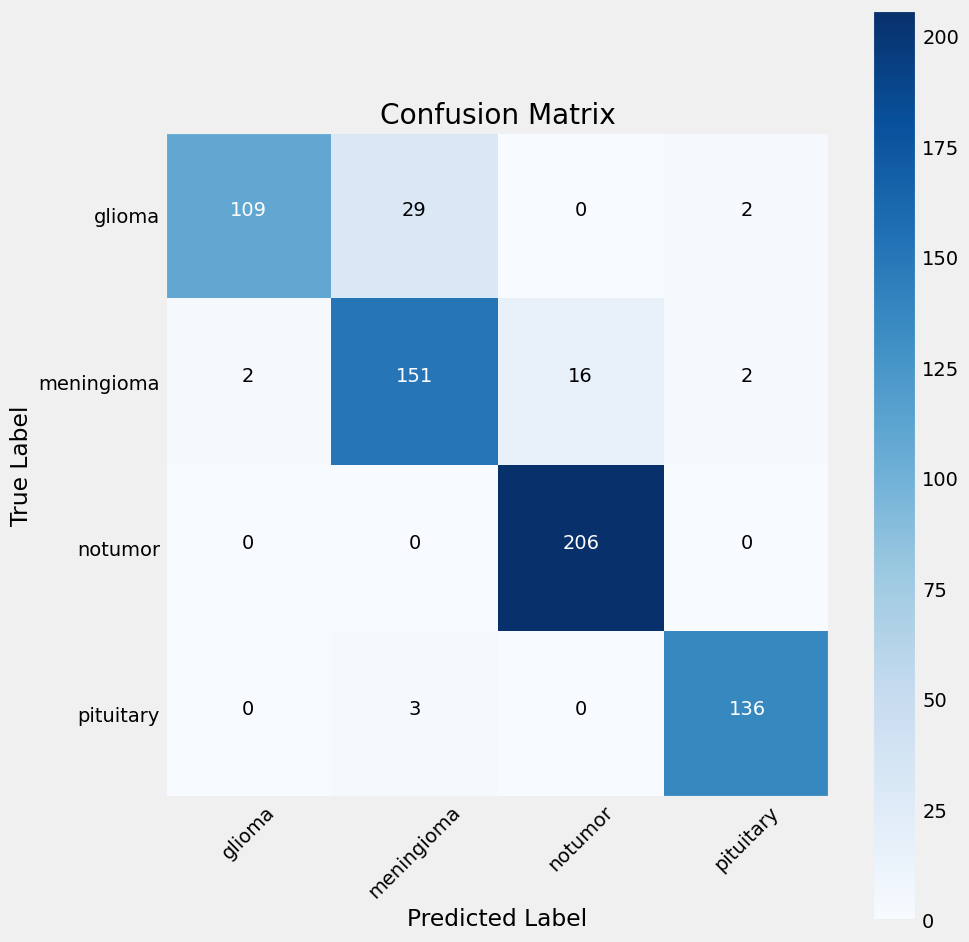

In [15]:
g_dict = test_genrator.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_genrator.classes, y_pred)
cm

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

plt.grid(visible=None)

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

# Classification Report

In [16]:
print(classification_report(test_genrator.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      glioma       0.98      0.78      0.87       140
  meningioma       0.83      0.88      0.85       171
     notumor       0.93      1.00      0.96       206
   pituitary       0.97      0.98      0.97       139

    accuracy                           0.92       656
   macro avg       0.93      0.91      0.91       656
weighted avg       0.92      0.92      0.92       656



In [17]:
def predict(img_path):
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image
    label = list(g_dict.keys()) 
    plt.figure(figsize=(12, 12))
    img = Image.open(img_path)
    resized_img = img.resize((224, 224))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    predictions = model.predict(img)
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


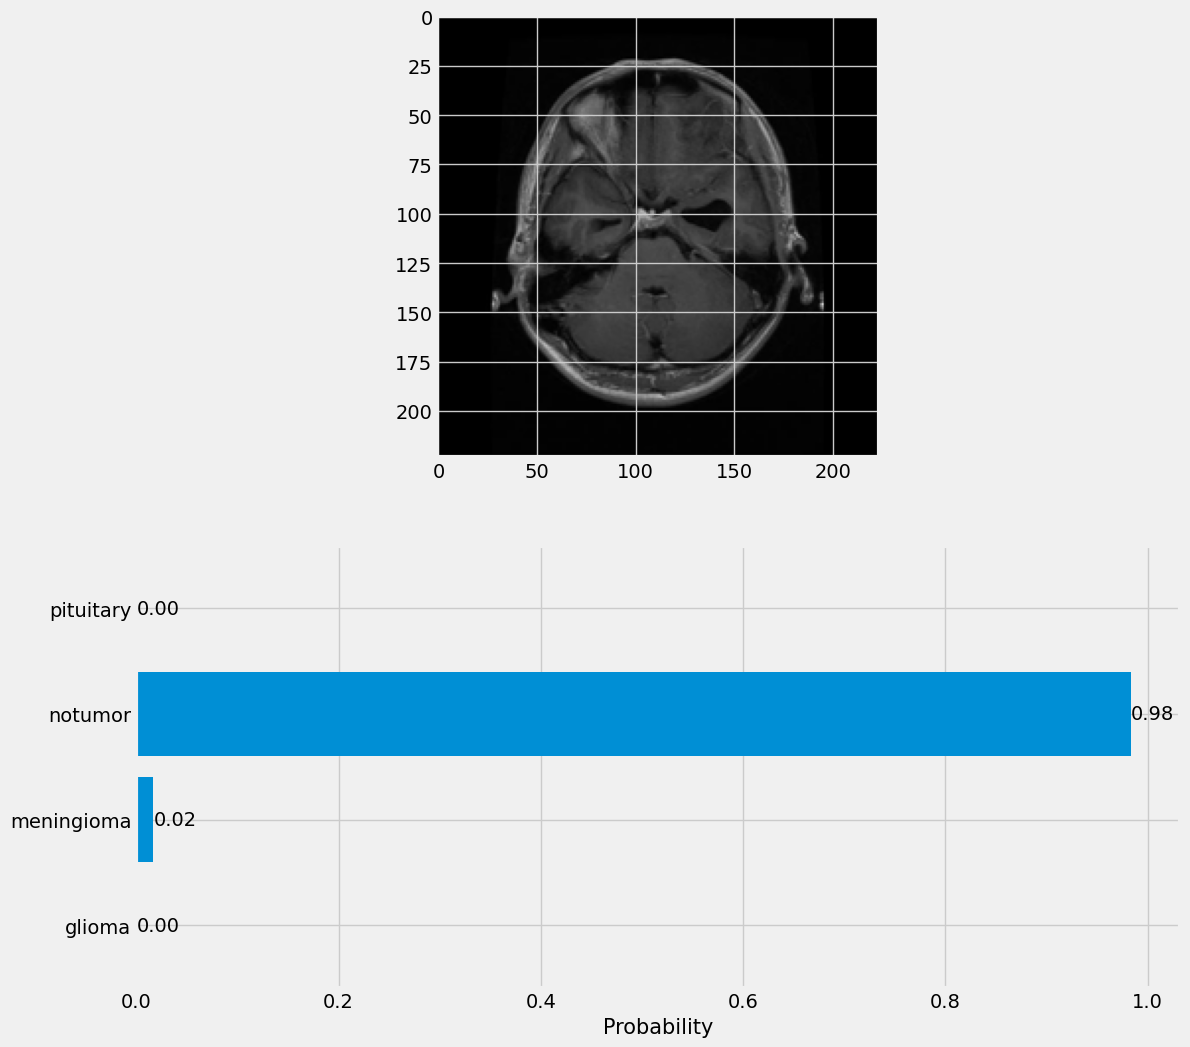

In [18]:
predict('/kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-glTr_0004.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


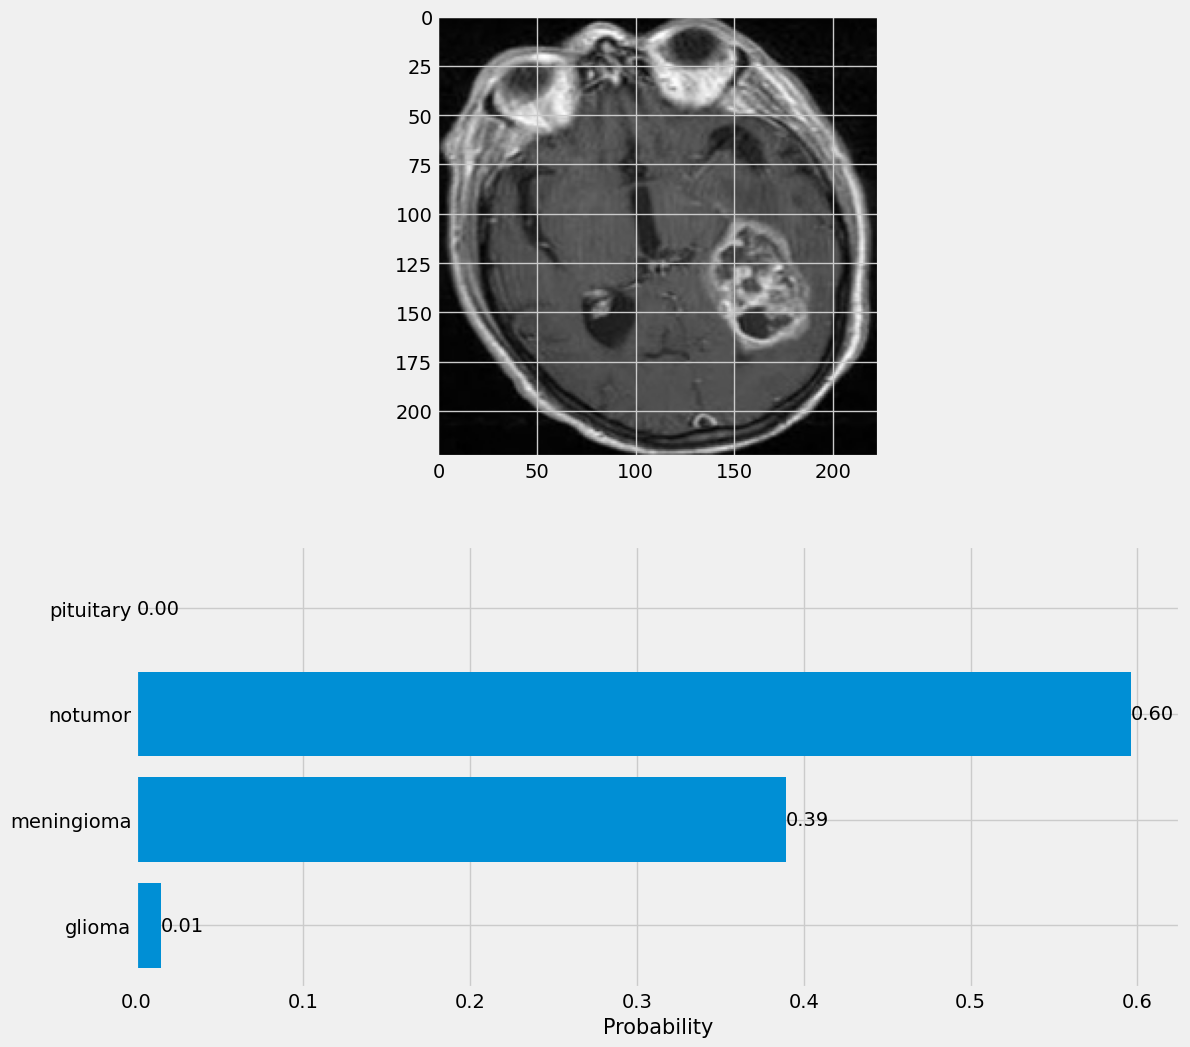

In [19]:
predict('/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-meTr_0001.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


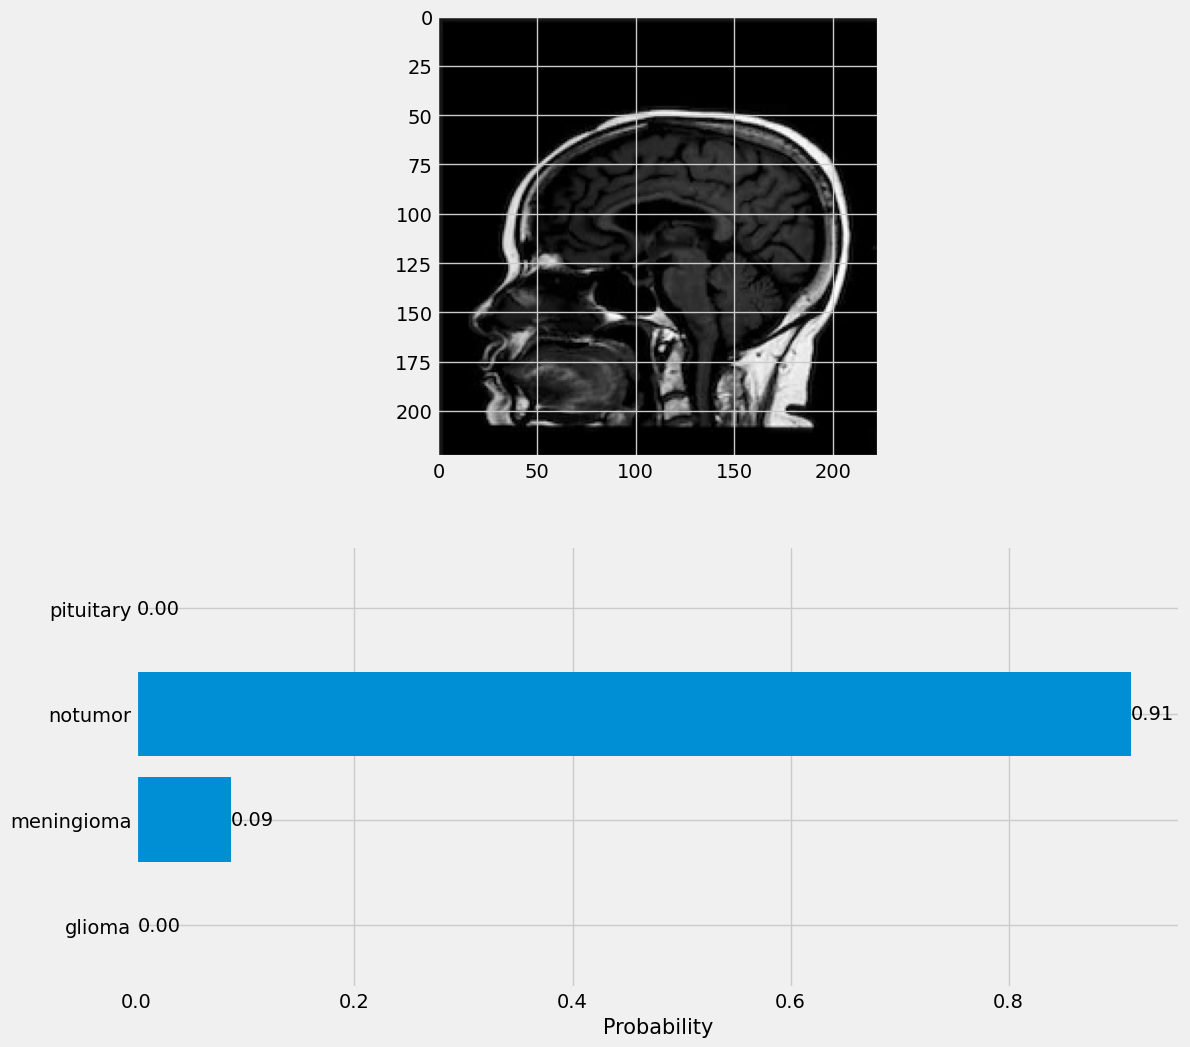

In [20]:
predict('/kaggle/input/brain-tumor-mri-dataset/Testing/notumor/Te-noTr_0004.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


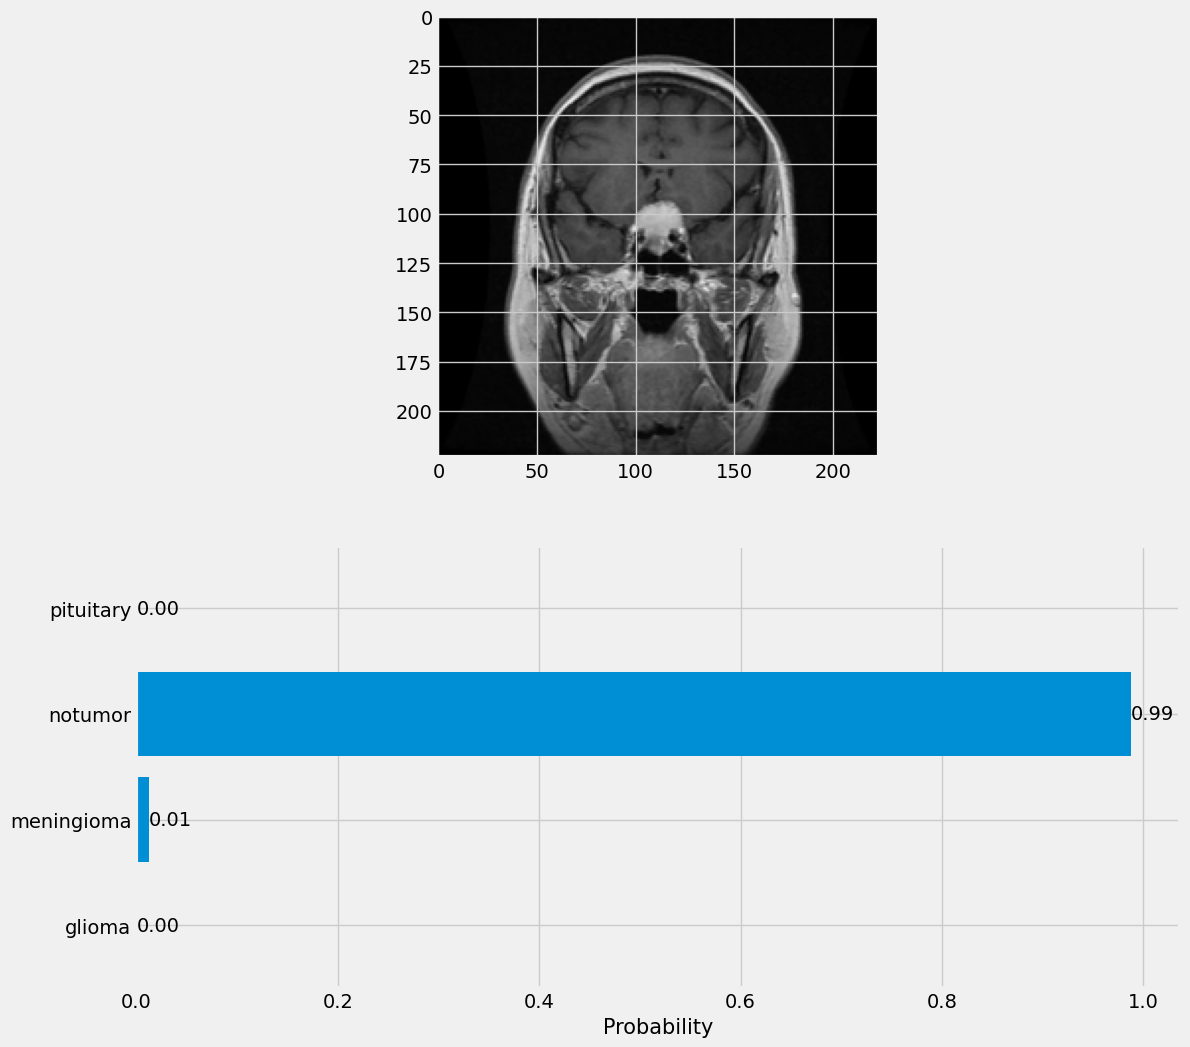

In [21]:
predict('/kaggle/input/brain-tumor-mri-dataset/Testing/pituitary/Te-piTr_0002.jpg')